In [1]:
import logging
import sys
from pathlib import Path


logging.basicConfig(
    level=logging.INFO,
    format="%(levelname)s: %(message)s",
    force=True,
)

# Add the src directory to the Python path
sys.path.append(str(Path.cwd().parent.parent))

In [2]:
from src.nas.mlp_chromosome import MLPChromosome


low, high = MLPChromosome.get_bounds()
low, high

(array([0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([7, 3, 8, 7, 8, 7, 8, 7, 7, 3, 4, 3, 1, 1, 2, 6, 3]))

In [5]:
from src.nas.mlp_nas_problem import MlpNasProblem
from src.nas.nas_params import NasParams
from src.datasets.vertebral_dataset import VertebralDataset
from src.datasets.breast_cancer_dataset import BreastCancerDataset
from src.nas.plot import hist_accuracies


DatasetClass = VertebralDataset
params = NasParams(
    epochs=15,
    patience=5,
    amount_of_evaluations=1,
    population_size=30,
    population_offspring_count=10,
    algorithm_generations=1,
    population_store_file=DatasetClass.__name__ + "_population.csv",
)
problem = MlpNasProblem(params, DatasetClass)

problem.get_min_complexity(), problem.get_max_complexity()

(64.8, np.float64(2160.0))

In [6]:
plow = problem.get_nn_params(MLPChromosome.parse(low))
phigh = problem.get_nn_params(MLPChromosome.parse(high))

plow.get_complexity(), phigh.get_complexity()

(64.8, np.float64(2160.0))

In [7]:
from pymoo.optimize import minimize

from src.constants import SEED


algorithm = params.get_algorithm()
termination = params.get_termination()

res = minimize(problem, algorithm, verbose=True, seed=SEED, termination=termination)

if params.population_store_file is not None:
    params.store_population(res, params.population_store_file)

print(f"Solutions: {res.X}")
print(f"Objectives: {res.F}")

INFO: Population file `VertebralDataset_population.csv` is empty. Using random sampling


n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |       30 |      4 |             - |             -
Solutions: [[4 1 1 0 3 0 7 5 7 2 4 2 0 0 2 4 1]
 [6 0 8 7 8 4 5 5 3 0 0 2 1 1 0 2 0]
 [5 1 1 7 6 1 7 0 4 0 3 2 1 0 1 4 1]
 [4 0 2 7 4 4 7 7 6 1 0 1 0 0 1 3 0]]
Objectives: [[-0.19354839  0.        ]
 [-0.91935484  0.05589757]
 [-0.62903226  0.01118518]
 [-0.67741935  0.04088437]]


In [21]:
df = problem.result_as_df(res)
df

,Accuracy,Complexity,fc,train,Chromosome
0,76.363636,93.600000,"{'layers': [{'height': 13, 'compression': NNPa...",{'DatasetCls': <class 'src.datasets.breast_can...,"[1, 0, 6, 7, 6, 2, 5, 6, 5, 2, 2, 3, 1, 1, 0, ..."
1,80.000000,381.323427,"{'layers': [{'height': 13, 'compression': NNPa...",{'DatasetCls': <class 'src.datasets.breast_can...,"[3, 2, 2, 6, 5, 5, 1, 5, 3, 0, 3, 3, 0, 0, 1, ..."
2,81.818182,745.200000,"{'layers': [{'height': 13, 'compression': NNPa...",{'DatasetCls': <class 'src.datasets.breast_can...,"[7, 2, 5, 3, 1, 1, 3, 5, 4, 2, 0, 0, 0, 0, 1, ..."
3,78.571429,141.919433,"{'layers': [{'height': 13, 'compression': NNPa...",{'DatasetCls': <class 'src.datasets.breast_can...,"[0, 2, 1, 6, 3, 7, 3, 1, 5, 2, 0, 2, 0, 0, 1, ..."


In [22]:
from pprint import pprint

ch = MLPChromosome.parse(df.loc[0]["Chromosome"])
params = problem.get_nn_params(ch)
pprint(params)

MLPParams(fc=FCParams(layers=[FCLayerParams(height=13,
                                            compression=<NNParamsCompMode.NBITS: 'nbits'>,
                                            bitwidth=2),
                              FCLayerParams(height=2,
                                            compression=<NNParamsCompMode.BINARY: 'binary'>,
                                            bitwidth=6)],
                      activation=ActivationParams(activation=<Activation.BINARIZE: 'binary'>,
                                                  binary_qmode=<QMode.STOCH: 'stoch'>,
                                                  reste_o=4.0,
                                                  reste_threshold=1.5),
                      qmode=<QMode.STOCH: 'stoch'>,
                      dropout_rate=0.0),
          train=NNTrainParams(DatasetCls=<class 'src.datasets.breast_cancer_dataset.BreastCancerDataset'>,
                              train_loader=<torch.utils.data.dataloader.Data

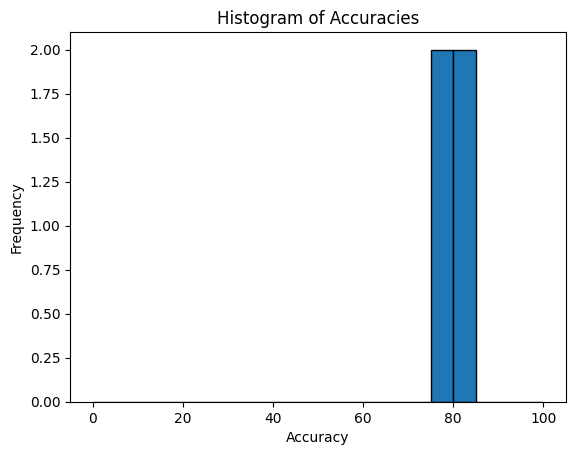

In [23]:
fig = hist_accuracies(df["Accuracy"])

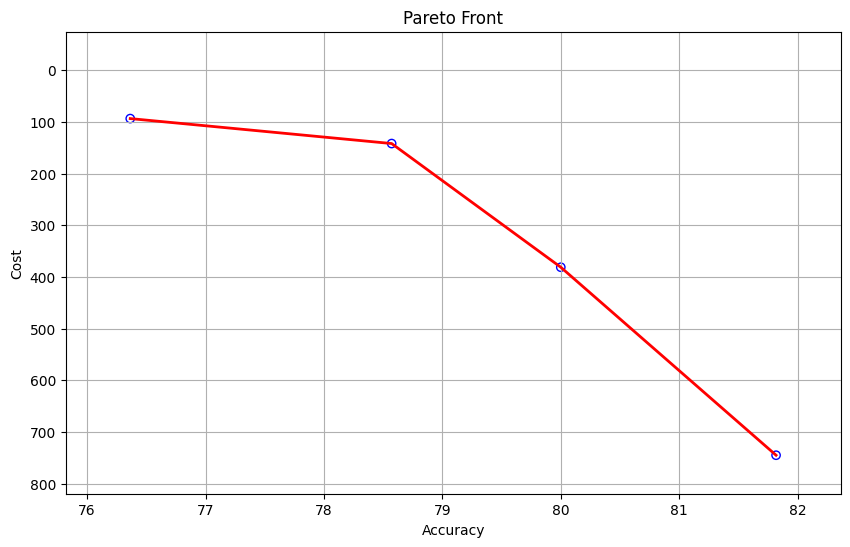

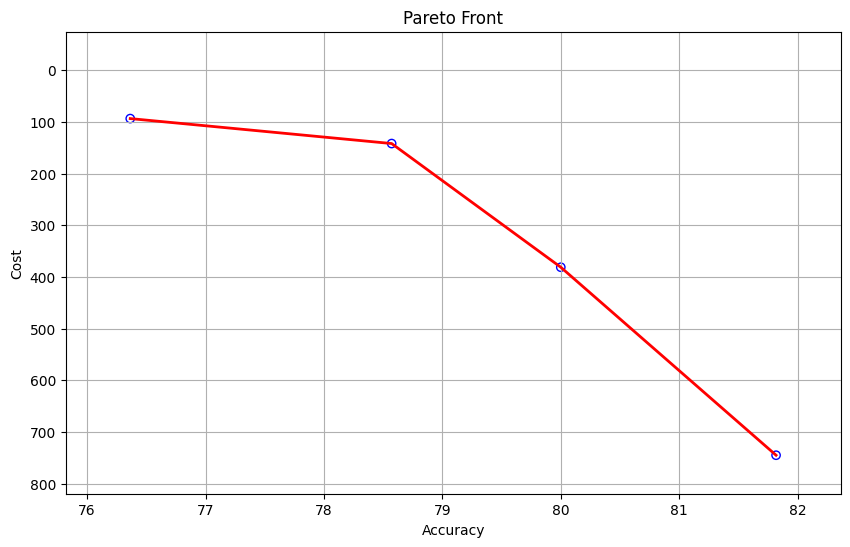

In [24]:
from src.nas import plot

plot.plot_pareto_front(df["Accuracy"], df["Complexity"])